# Real Estate Moscow Price Prediction

### Библиотеки, скрипты, загрузка данных

In [1]:
import numpy as np
import pandas as pd 
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры



In [3]:
# загрузка
TRAIN_DATASET_PATH = 'real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'real-estate-price-prediction-moscow/test.csv'

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

print("Is DFs equal:", train_df.shape[1] - 1 == test_df.shape[1])

Is DFs equal: True


### Приведение типов

In [4]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [5]:
# перевод в строку некоторых признаков
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1.EDA

**Целевая переменная**

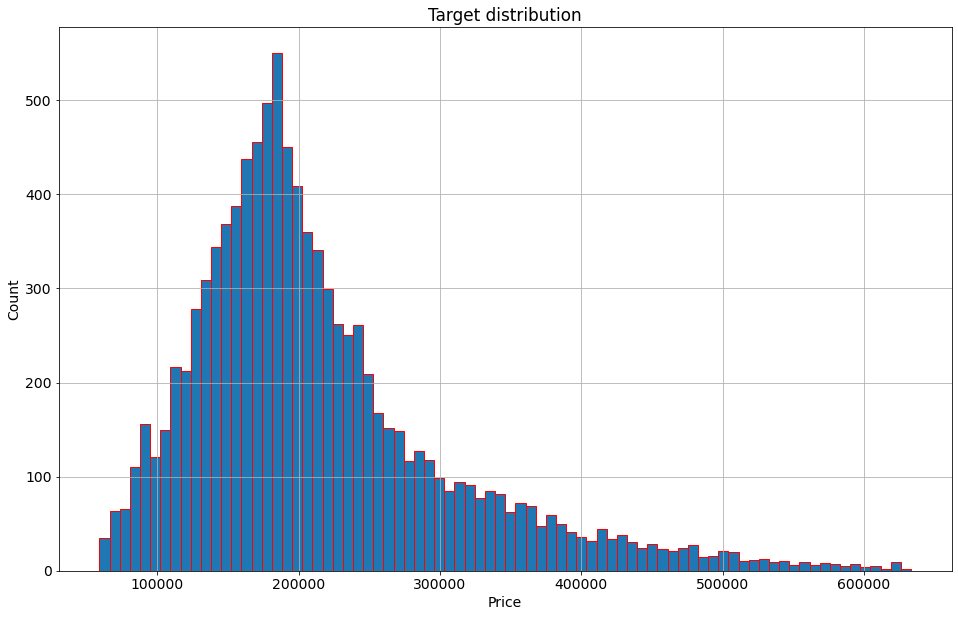

In [9]:
plt.figure(figsize = (16, 10))

train_df['Price'].hist(bins=80, ec="red")
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [10]:
train_df.describe()
# count < 10000: пропуски
# mean и квантиль 50%: если сильное отличие - выбросы
# выбросы в min и max

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [11]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [12]:
train_df['DistrictId'].value_counts()
# категориальный признак, нужно перевести в вещественный, лучше через собственные значения value_count

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
117      1
199      1
174      1
196      1
Name: DistrictId, Length: 205, dtype: int64

In [13]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

## 2.Обработка выбросов
**Rooms**


In [15]:
#Смотрим выбросы количества комнат
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [16]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1
train_df['Rooms_outlier'].value_counts()

0    9989
1      11
Name: Rooms_outlier, dtype: int64

In [17]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

**KitchenSquare**

In [18]:
#Смотрим выбросы площади кухни
print(train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025))
train_df['KitchenSquare'].value_counts()

13.0 0.0


1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [19]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [20]:
train_df['HouseFloor'].sort_values().unique()
#В Москве макс. 95 этажей

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [21]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [22]:
# Количество этажей больше этажности дома
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [23]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))
#Дом выше максимально высокого дома в Москве
max_floor_outliers = train_df.loc[train_df['Floor'] > 95].index
train_df.loc[max_floor_outliers, 'Floor'] = train_df['HouseFloor'].median()

In [24]:
# Проверяем остались ли выбросы
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [25]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [26]:
#Дом старше тек. года приравниваем к медиане
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = train_df['HouseYear'].median()

## 3.Обработка пропусков

In [27]:
#Проверка пропусков
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

**LifeSquare**

In [28]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
# Находим пустые LifeSquare и заполняем        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1 predict**

In [29]:
train_df["Hc1_edit"] = 0
train_df.loc[train_df["Healthcare_1"].isna(), "Hc1_edit"] = 1
train_df[["Healthcare_1", "Hc1_edit"]]


,Healthcare_1,Hc1_edit
0,NaN,1
1,1183.0,0
2,240.0,0
3,NaN,1
4,NaN,1
...,...,...
9995,NaN,1
9996,NaN,1
9997,NaN,1
9998,125.0,0


In [30]:
class Healthcare1FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
#         self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms


#         if y is not None:
#             df['Price'] = y.values
            
#             self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                                             .rename(columns={'Price':'MedPriceByDistrict'})
            
#             self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        df = X.copy()
        
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0

        X.loc[X["DistrictSize"].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
#         if self.med_price_by_district is not None:
#             X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
#             X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        X["NonResSquare"] = X["Square"] - X["LifeSquare"] - X["KitchenSquare"]
        X.loc[X["NonResSquare"] < 3, "NonResSquare"] = 3
    
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
        
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 7, 9, 12, 14, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1900, 1945, 1960, 1970, 1980, 2000, 2010, 2015, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [31]:
class Healthcare1DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] < 0, 'HouseFloor'] = abs(X.loc[X['HouseFloor'] < 0, 'HouseFloor'])
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = self.medians['Floor']
        
        max_floor_outliers = X.loc[X['Floor'] > 95].index
        X.loc[max_floor_outliers, 'Floor'] = self.medians['HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] < 0, 'HouseYear_outlier'] = 1                      
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] < 0, 'HouseYear'] = current_year
                                               
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3          
            
        X.fillna(self.medians, inplace=True)
        
        return X

# Healthcare1_predict

In [32]:
def healthcare1_pred(train_df):
    
            
    train_df["Hc1_edit"] = 0
    train_df.loc[train_df["Healthcare_1"].isna(), "Hc1_edit"] = 1 
        
    hc1_train_df = train_df.loc[train_df["Healthcare_1"].notna(), train_df.columns].copy()

    hc1_test_df = train_df.loc[train_df["Healthcare_1"].isna(), train_df.columns].copy()
    
    target_name = 'Healthcare_1'

    hc1_test_df = hc1_test_df.drop('Healthcare_1', axis=1)

    X = hc1_train_df.drop(columns=target_name)
    y = hc1_train_df[target_name]

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
    
    hc1_preprocessor = Healthcare1DataPreprocessing()
    hc1_preprocessor.fit(X_train)
    hc1_preprocessor.fit(X_valid)
    hc1_preprocessor.fit(hc1_test_df)

    X_train = hc1_preprocessor.transform(X_train)
    X_valid = hc1_preprocessor.transform(X_valid)
    hc1_test_df = hc1_preprocessor.transform(hc1_test_df)
    
    hc1_features_gen = Healthcare1FeatureGenetator()
    hc1_features_gen.fit(X_train, y_train)
    hc1_features_gen.fit(hc1_test_df)
    
    X_train = hc1_features_gen.transform(X_train)
    X_valid = hc1_features_gen.transform(X_valid)
    hc1_test_df = hc1_features_gen.transform(hc1_test_df)
    
    hc1_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=40)

    hc1_model.fit(X_train, y_train)
    
    y_train_preds = hc1_model.predict(X_train)
    y_test_preds = hc1_model.predict(X_valid)

    y_hc1_preds = hc1_model.predict(hc1_test_df)
    
    train_df.loc[train_df["Hc1_edit"] == 1, "Healthcare_1"] =  y_hc1_preds.round()
    
    return train_df


In [33]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] < 0, 'HouseFloor'] = abs(X.loc[X['HouseFloor'] < 0, 'HouseFloor'])
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = self.medians['Floor']
        
        max_floor_outliers = X.loc[X['Floor'] > 95].index
        X.loc[max_floor_outliers, 'Floor'] = self.medians['HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] < 0, 'HouseYear_outlier'] = 1                      
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] < 0, 'HouseYear'] = current_year
                                               
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        # Healthcare_1
#         X["Hc1_edit"] = 0
#         X.loc[X["Healthcare_1"].isna(), "Hc1_edit"] = 1
#         X.loc[X["Healthcare_1"].isna(), "Healthcare_1"] = X["Healthcare_1"].median()
        
        
        return X

## 4.Построение новых признаков

**Dummies**

In [34]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, isDistrictLarge**

In [35]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [36]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Hc1_edit,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,NaN,0,0,1,305018.871089,0,0,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,NaN,0,1,1,168106.007630,0,0,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,NaN,0,6,1,343995.102962,0,0,0,1,89


In [37]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [38]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [39]:
train_df['new_district'] = 0
train_df.loc[train_df["DistrictSize"].isna(), 'new_district'] = 1
train_df['DistrictSize'].fillna(5, inplace=True)

**MedPriceByFloorYear**

In [40]:
def floor_to_cat(X):
    bins = [0, 3, 5, 7, 9, 12, 14, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X



def year_to_cat(X):
    bins = [0, 1900, 1945, 1960, 1970, 1980, 2000, 2010, 2015, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [41]:
bins = [0, 3, 5, 7, 9, 12, 14, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       4
4       6
       ..
9995    0
9996    5
9997    0
9998    0
9999    3
Name: Floor, Length: 10000, dtype: int64

In [42]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Hc1_edit,DistrictSize,IsDistrictLarge,new_district,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,1,851,1,0,7,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,78,0,0,3,2
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,652,1,0,5,0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,1,652,1,0,4,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,1,89,0,0,4,6


In [43]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,0,374737.658654
1,1,1,321488.560449
2,1,2,429090.881284
3,1,3,315438.466075
4,1,4,274992.472366


In [44]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Hc1_edit,DistrictSize,IsDistrictLarge,new_district,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,1,851,1,0,7,1,157369.258829
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,0,3,2,206441.718697
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,0,5,0,204670.096676
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,1,652,1,0,4,4,181627.349941
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,1,89,0,0,4,6,175768.013733


**NonResidentialSquare**

In [45]:
#Нежилая площадь
train_df["NonResSquare"] = train_df["Square"] - train_df["LifeSquare"] - train_df["KitchenSquare"]
train_df.loc[train_df["NonResSquare"] < 3, "NonResSquare"] = 3
train_df["NonResSquare"]

0        3.000000
1        8.663301
2       20.670243
3        3.000000
4       16.722551
          ...    
9995     9.818102
9996    18.269264
9997     8.092693
9998     5.003423
9999     7.514109
Name: NonResSquare, Length: 10000, dtype: float64

**MetaParam**

In [46]:
train_df['MetaParam_1'] = train_df["Square"] + train_df["Rooms"]

train_df['MetaParam_1']

0       118.027311
1        40.832524
2        81.342215
3        41.409907
4        66.285067
           ...    
9995     51.090728
9996     66.307684
9997     30.648057
9998     33.330292
9999     36.815476
Name: MetaParam_1, Length: 10000, dtype: float64

**DistrictOld**

In [47]:
district_old = train_df.groupby(['DistrictId'], as_index=False).agg({'HouseYear':'median'})
train_df = train_df.merge(district_old, on=['DistrictId'], how='left') 

**Lift**

In [48]:
train_df["Lift"] = 0
train_df.loc[train_df["HouseFloor"] > 5 , "Lift"] = 1
train_df["Lift"]

0       1
1       1
2       1
3       1
4       1
       ..
9995    1
9996    1
9997    0
9998    1
9999    1
Name: Lift, Length: 10000, dtype: int64

In [49]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
#         self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms


#         if y is not None:
#             df['Price'] = y.values
            
#             self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                                             .rename(columns={'Price':'MedPriceByDistrict'})
            
#             self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        df = X.copy()
        
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0

        X.loc[X["DistrictSize"].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
#         if self.med_price_by_district is not None:
#             X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
#             X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        X["NonResSquare"] = X["Square"] - X["LifeSquare"] - X["KitchenSquare"]
        X.loc[X["NonResSquare"] < 3, "NonResSquare"] = 3
    
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        #MetaParams
        X['MetaParam_1'] = X["Square"] + X["Rooms"]
        X["MetaParam2"] = X["Social_1"] + X["Social_2"] + X["Social_3"]
        X["MetaParam3"] = X["Ecology_1"] + X["Ecology_2"] + X["Ecology_3"]
        
        #Lift
        X["Lift"] = 0
        X.loc[X["HouseFloor"] > 5 , "Lift"] = 1
        
        return X
        
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 7, 9, 12, 14, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1900, 1945, 1960, 1970, 1980, 2000, 2010, 2015, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

## 4. Отбор признаков и разбиение на train и test

In [50]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'Hc1_edit', 'DistrictSize',
                     'IsDistrictLarge', 'new_district', 'year_cat', 'floor_cat', 'MedPriceByFloorYear',
                     'NonResSquare', 'MetaParam_1','MetaParam2', 'Lift']

target_name = 'Price'

In [51]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

train_df = healthcare1_pred(train_df)
test_df = healthcare1_pred(test_df)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [52]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape
X_train.dtypes

Id                       int64
DistrictId               int64
Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                  float64
HouseFloor             float64
HouseYear                int64
Ecology_1              float64
Ecology_2                int64
Ecology_3                int64
Social_1                 int64
Social_2                 int64
Social_3                 int64
Healthcare_1           float64
Helthcare_2              int64
Shops_1                  int64
Shops_2                  int64
Hc1_edit                 int64
Rooms_outlier            int64
HouseFloor_outlier       int64
HouseYear_outlier        int64
LifeSquare_nan           int32
DistrictSize             int64
new_district             int64
IsDistrictLarge          int32
floor_cat                int64
year_cat                 int64
NonResSquare           float64
MedPriceByFloorYear    float64
MetaParam_1            float64
MetaPara

In [53]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 7.Построение модели
**Обучение**

Train R2:	0.833
Test R2:	0.746


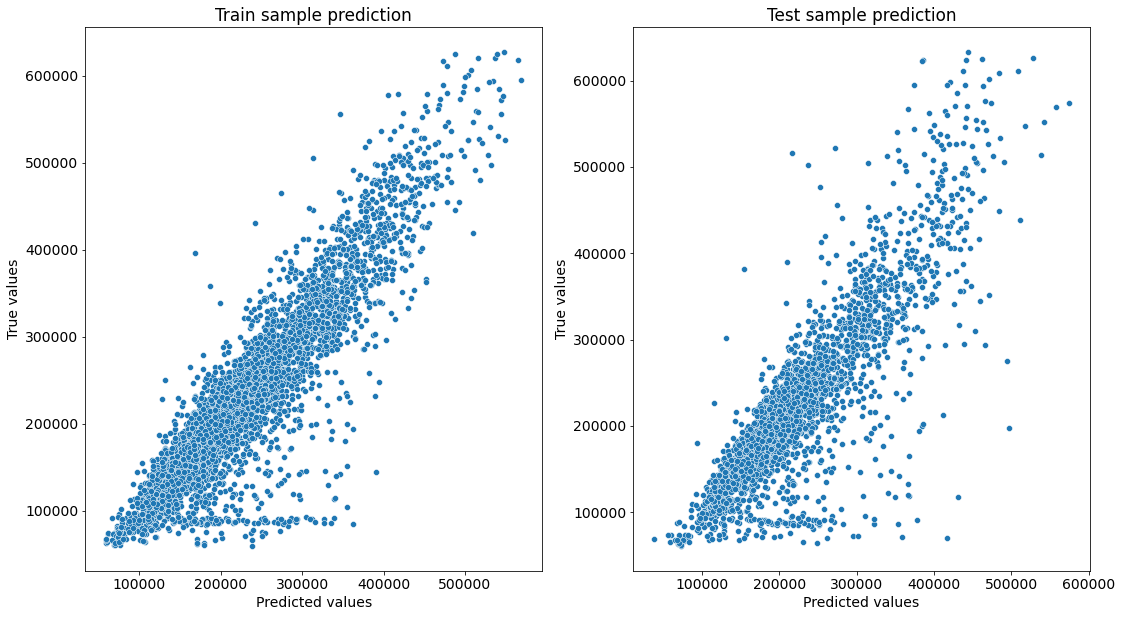

In [54]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=5,
                                     random_state=42,
                                     n_estimators=290,
                                     max_depth=3
                                     )

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [55]:
# %%time
# params = {'n_estimators':[300, 350, 400], 
#           'max_depth':[3, 5, 7]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [56]:
# res = pd.DataFrame(gs.cv_results_)
# res.head(2)

In [57]:
# gs.best_params_

In [58]:
# gs.best_score_

**Кросс-валидация**

In [59]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score.mean()

0.7168283811316994

**Важность признаков**

In [60]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
28,MetaParam_1,0.378011
21,DistrictSize,0.250191
1,Square,0.084951
12,Social_3,0.045098
26,MedPriceByFloorYear,0.035751
7,Ecology_1,0.027348
0,Rooms,0.026653
10,Social_1,0.025805
13,Healthcare_1,0.020063
11,Social_2,0.019644


In [61]:
X_train.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Hc1_edit',
 'DistrictSize',
 'IsDistrictLarge',
 'new_district',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'NonResSquare',
 'MetaParam_1',
 'MetaParam2',
 'Lift']

Train R2:	0.833
Test R2:	0.746


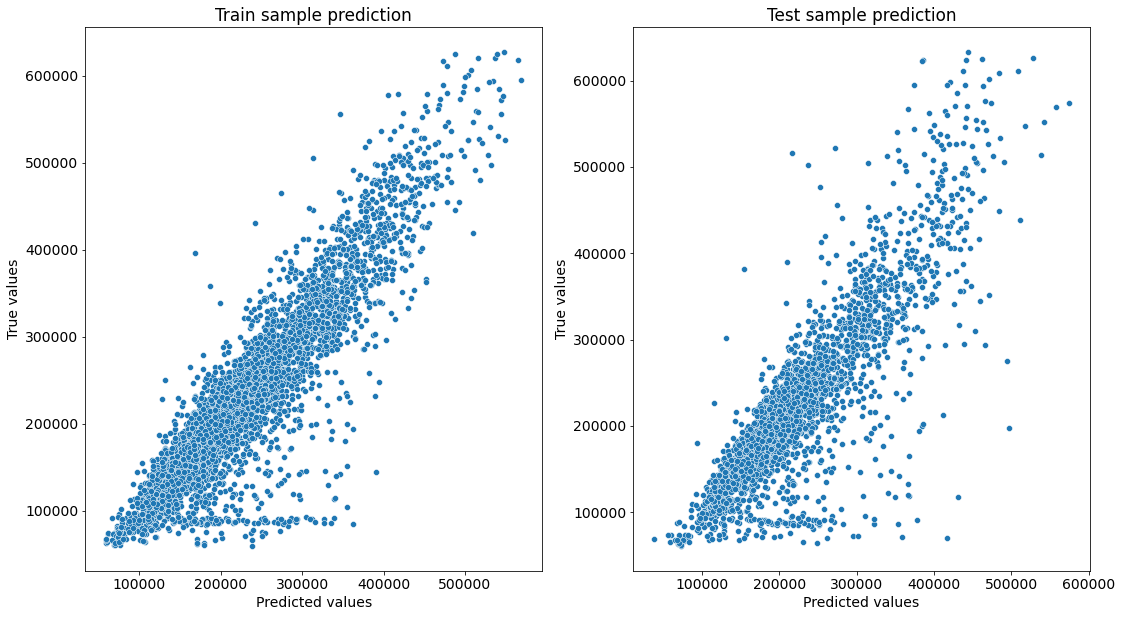

In [62]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 8. Прогнозирование на тестовом датасете

In [63]:
test_df.shape

(5000, 31)

In [64]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,DistrictSize,IsDistrictLarge,new_district,year_cat,floor_cat,MedPriceByFloorYear,NonResSquare,MetaParam_1,MetaParam2,Lift
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,70.0,0,0,3,1.0,189132.246105,12.753448,37.847630,4402,1
1,1.0,42.493907,42.568133,10.0,7.0,17.0,2017,0.072158,1,1,...,164.0,1,0,8,2.0,195032.912180,3.000000,43.493907,632,1
2,2.0,59.463678,47.463678,9.0,19.0,19.0,1977,0.211401,1,1,...,568.0,1,0,4,6.0,174542.759531,3.000000,61.463678,1901,1
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,375.0,1,0,3,0.0,178315.959914,9.752204,52.646030,477,0
4,1.0,53.837056,47.837056,3.0,8.0,17.0,1977,0.309479,1,1,...,76.0,0,0,4,3.0,185730.077524,3.000000,54.837056,7754,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,7.0,5.0,1962,0.069660,1,1,...,59.0,0,0,3,2.0,188031.945499,7.837576,45.177521,6154,0
4996,3.0,93.698122,94.521465,10.0,21.0,27.0,2018,0.060753,1,1,...,25.0,0,0,8,6.0,219944.370266,3.000000,96.698122,2804,1
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966,0.038693,1,1,...,69.0,0,0,3,0.0,178315.959914,9.653464,34.656723,6562,0
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,0.089040,1,1,...,35.0,0,0,3,3.0,201388.443647,8.658898,39.635155,8014,1


In [65]:
submit = pd.read_csv('real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [66]:
predictions = gb_model.predict(test_df)
predictions

array([164878.66464159, 144419.16019917, 186694.18355872, ...,
       139883.27935674, 190817.32681559, 270621.81944023])

In [67]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164878.664642
1,5925,144419.160199
2,960,186694.183559
3,3848,149266.499975
4,746,204699.495016


In [68]:
submit.to_csv('course_submit1.csv', index=False)